In [16]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.sparse as sp
import pandas as pd
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import matthews_corrcoef
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, roc_auc_score

import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Dense,Reshape,GlobalMaxPool1D,MaxPool1D,Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import activations, regularizers, constraints, initializers
import tensorflow.keras.backend as K
tf.keras.utils.set_random_seed(123)
tf.random.set_seed(123)

ppi=pd.read_csv('data/BRCA/ppi_network_of_BRCA.csv')
expression= pd.read_csv('data/BRCA/RPPA_data_of_BRCA.csv')
cancertype= pd.read_csv('data/BRCA/clinical_data_of_BRCA.csv')
cancertype=cancertype[['patient','BRCA_Subtype_PAM50']]
expression=expression.transpose()

expression.reset_index(inplace=True)
expression.columns = expression.iloc[0]
expression = expression[1:]
expression["Sample_description"] = expression["Sample_description"].apply(lambda x: x[:12])
expression

,Sample_description,1433EPSILON,4EBP1,4EBP1PS65,4EBP1PT37T46,53BP1,ACCPS79,ACC1,AKT,AKTPS473,...,XRCC1,YAP,YAPPS127,YB1,YB1PS102,JNKPT183Y185,PAI1,MTORPS2448,ASNS,EGFR
1,TCGA-A1-A0SF,-0.272394,0.202995,-0.214957,-0.023729,-0.030892,0.60463,0.268486,0.085798,-0.225008,...,0.097993,-0.243608,0.05255,-0.489067,-0.261067,0.629659,-0.358461,-0.104804,-0.830766,-0.463626
2,TCGA-A1-A0SH,-0.173035,-0.248155,-0.351737,-0.475157,-0.404451,1.514143,1.432223,0.297448,-0.21324,...,-0.207396,-0.157191,0.155374,-0.234074,-0.116958,0.704078,-0.20983,0.045693,-0.501462,-0.382157
3,TCGA-A1-A0SJ,0.134756,-0.013049,-0.443333,-1.269039,-0.563984,0.248792,0.457292,-0.021407,-0.835423,...,-0.351546,0.134392,0.918799,-0.152936,-0.410581,-0.103755,1.149835,-0.196576,-0.024455,-0.305019
4,TCGA-A1-A0SK,0.11944,2.068829,0.078068,0.879273,-0.205781,-0.681365,-0.705412,-0.131826,-1.166382,...,0.306415,-0.438928,-1.151397,-0.334132,-0.327847,-0.001032,1.324089,-0.324952,0.653881,-0.3969
5,TCGA-A1-A0SO,-0.079641,0.088545,-0.100215,0.32937,-0.079728,0.746355,0.613443,0.501999,-0.722703,...,0.286287,-0.241619,-0.288027,-0.065122,-0.112794,0.236262,0.583274,-0.222981,0.503767,-0.223176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
743,TCGA-GM-A3XL,0.052733,-0.072883,-0.353865,-0.156991,-0.894661,0.393416,0.526831,0.239058,-0.551161,...,0.1854,-0.151531,-0.409902,-0.396955,-0.151445,0.648761,0.556354,-0.046665,0.853853,0.127361
744,TCGA-GM-A3XN,0.099206,-0.003247,-0.302553,-0.143475,0.146624,-0.623496,-0.556858,0.628138,0.316104,...,0.103693,-0.110986,0.27078,-0.037609,-0.220472,0.504634,0.704081,0.120001,-0.232645,-0.375748
745,TCGA-HN-A2NL,-0.025698,-0.356748,-0.364129,0.413819,-0.962322,0.655543,0.391684,-0.193728,0.233813,...,-0.499625,0.236992,0.287361,-0.3004,0.046731,-0.036305,-0.171193,-0.161576,0.311806,0.214449
746,TCGA-JL-A3YW,-0.127815,-0.472337,-0.212296,-0.633701,-0.374044,0.336867,0.298615,-0.005465,0.426084,...,-0.302034,0.103741,0.231723,0.363791,-0.040417,-0.193765,1.765091,0.034537,-0.307715,0.405887


Define the diffusion module

In [17]:
def Diffusion(A: sp.csr_matrix, alpha: float, eps: float):
    N = A.shape[0]

    A_loop = sp.eye(N) + A

    D_loop_vec = A_loop.sum(0).A1
    D_loop_vec_invsqrt = 1 / np.sqrt(D_loop_vec)
    D_loop_invsqrt = sp.diags(D_loop_vec_invsqrt)
    T_sym = D_loop_invsqrt @ A_loop @ D_loop_invsqrt

    # PPR-based diffusion
    S = alpha * sp.linalg.inv(sp.eye(N) - (1 - alpha) * T_sym)

    # Sparsify using threshold epsilon
    S_tilde = S.multiply(S >= eps)

    # Column-normalized transition matrix on graph S_tilde
    D_tilde_vec = S_tilde.sum(0).A1
    
    T_S = S_tilde / D_tilde_vec
    
    return T_S

In [18]:
data= cancertype.merge(expression, left_on='patient', right_on='Sample_description')
data.dropna()
columns=data.columns.tolist()[3:]
columns
','.join(columns)

'1433EPSILON,4EBP1,4EBP1PS65,4EBP1PT37T46,53BP1,ACCPS79,ACC1,AKT,AKTPS473,AKTPT308,AMPKALPHA,AMPKPT172,AR,ATM,BAK,BAX,BCL2,BCLXL,BECLIN,BETACATENIN,BID,BIM,CJUNPS73,CKIT,CMETPY1235,CMYC,CRAF,CRAFPS338,CASPASE7CLEAVEDD198,CAVEOLIN1,CD31,CD49B,CDK1,CHK1,CHK1PS345,CHK2,CHK2PT68,CIAP,CLAUDIN7,COLLAGENVI,CYCLINB1,CYCLIND1,CYCLINE1,DJ1,DVL3,ECADHERIN,EEF2,EEF2K,EGFRPY1068,EGFRPY1173,EIF4E,ERALPHA,ERALPHAPS118,ERK2,FIBRONECTIN,FOXO3A,GAB2,GATA3,GSK3ALPHABETA,GSK3ALPHABETAPS21S9,HER2,HER2PY1248,HER3,HER3PY1298,HSP70,IGFBP2,INPP4B,IRS1,JNK2,KU80,LKB1,LCK,MAPKPT202Y204,MEK1,MEK1PS217S221,MIG6,MRE11,MTOR,NCADHERIN,NFKBP65PS536,NF2,NOTCH1,PCADHERIN,P27,P27PT157,P38MAPK,P38PT180Y182,P53,P70S6K,P70S6KPT389,P90RSKPT359S363,PAXILLIN,PCNA,PDK1PS241,PEA15,PI3KP110ALPHA,PKCALPHA,PKCALPHAPS657,PKCDELTAPS664,PR,PRAS40PT246,PTEN,RAD50,RAD51,RBPS807S811,S6,S6PS235S236,S6PS240S244,SHCPY317,SMAD1,SMAD3,SMAD4,SRC,SRCPY416,SRCPY527,STAT3PY705,STAT5ALPHA,STATHMIN,SYK,TUBERIN,VEGFR2,XRCC1,YAP,YAPPS127,YB1,YB1PS102

In [ ]:
Build the weighted PPI matrix

In [19]:
data1=data[columns]
corr = data1.corr()
adjoint=corr.applymap(lambda x:0)

for i in range(0,len(ppi)):
    node1=ppi.iloc[i,0]
    node2=ppi.iloc[i,1]
    
    correlation = np.corrcoef(expression[node1].tolist(), expression[node2].tolist())[0, 1]
    correlation=abs(correlation)
    adjoint.loc[node1,node2]=correlation
    adjoint.loc[node2,node1]=correlation

adjoint

,1433EPSILON,4EBP1,4EBP1PS65,4EBP1PT37T46,53BP1,ACCPS79,ACC1,AKT,AKTPS473,AKTPT308,...,XRCC1,YAP,YAPPS127,YB1,YB1PS102,JNKPT183Y185,PAI1,MTORPS2448,ASNS,EGFR
1433EPSILON,0,0.000000,0,0,0.0,0,0.0,0.000000,0,0,...,0.000000,0,0,0.000000,0,0,0.000000,0,0.000000,0.000000
4EBP1,0,0.000000,0,0,0.0,0,0.0,0.081242,0,0,...,0.000000,0,0,0.000000,0,0,0.000000,0,0.325689,0.025081
4EBP1PS65,0,0.000000,0,0,0.0,0,0.0,0.000000,0,0,...,0.000000,0,0,0.000000,0,0,0.000000,0,0.000000,0.000000
4EBP1PT37T46,0,0.000000,0,0,0.0,0,0.0,0.000000,0,0,...,0.000000,0,0,0.000000,0,0,0.000000,0,0.000000,0.000000
53BP1,0,0.000000,0,0,0.0,0,0.0,0.367663,0,0,...,0.129996,0,0,0.000000,0,0,0.000000,0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
JNKPT183Y185,0,0.000000,0,0,0.0,0,0.0,0.000000,0,0,...,0.000000,0,0,0.000000,0,0,0.000000,0,0.000000,0.000000
PAI1,0,0.000000,0,0,0.0,0,0.0,0.078264,0,0,...,0.000000,0,0,0.000000,0,0,0.000000,0,0.000000,0.190831
MTORPS2448,0,0.000000,0,0,0.0,0,0.0,0.000000,0,0,...,0.000000,0,0,0.000000,0,0,0.000000,0,0.000000,0.000000
ASNS,0,0.325689,0,0,0.0,0,0.0,0.000000,0,0,...,0.000000,0,0,0.000000,0,0,0.000000,0,0.000000,0.000000


In [20]:
sparse_matrix1 = csr_matrix(adjoint.values)
x=Diffusion(sparse_matrix1,0.4,0.005)
df=pd.DataFrame(x)
df

,0,1,2,3,4,5,6,7,8,9,...,121,122,123,124,125,126,127,128,129,130
0,1.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
1,0.0,0.560876,0.0,0.0,0.000000,0.0,0.0,0.008437,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.095955,0.004831
2,0.0,0.000000,1.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
3,0.0,0.000000,0.0,1.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
4,0.0,0.000000,0.0,0.0,0.532989,0.0,0.0,0.015475,0.0,0.0,...,0.028045,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.005374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,1.0,0.000000,0.0,0.000000,0.000000
127,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.007032,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.667378,0.0,0.000000,0.013273
128,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,1.0,0.000000,0.000000
129,0.0,0.090327,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.895250,0.000000


In [21]:
x2=df.applymap(lambda x: 1 if x != 0 else 0)
x2

,0,1,2,3,4,5,6,7,8,9,...,121,122,123,124,125,126,127,128,129,130
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
127,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
128,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
129,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


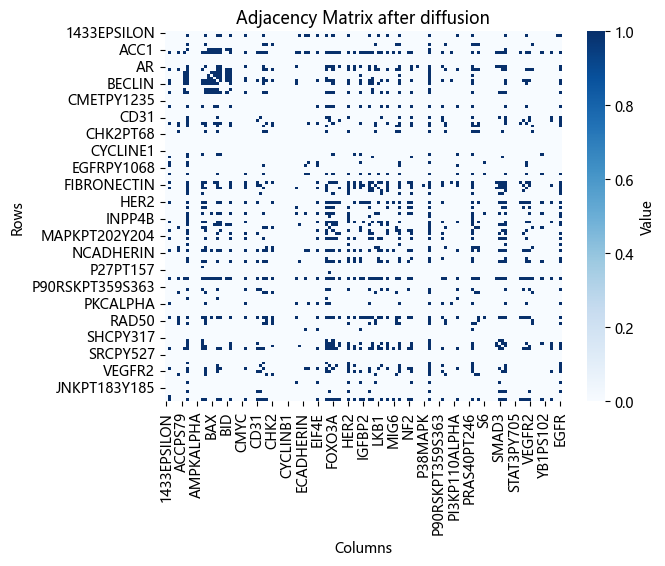

In [22]:
x0=adjoint.applymap(lambda x: 1 if x != 0 else 0)
sns.heatmap(x0, cmap='Blues', cbar_kws={'label': 'Value'})
plt.title('Adjacency Matrix before diffusion')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()

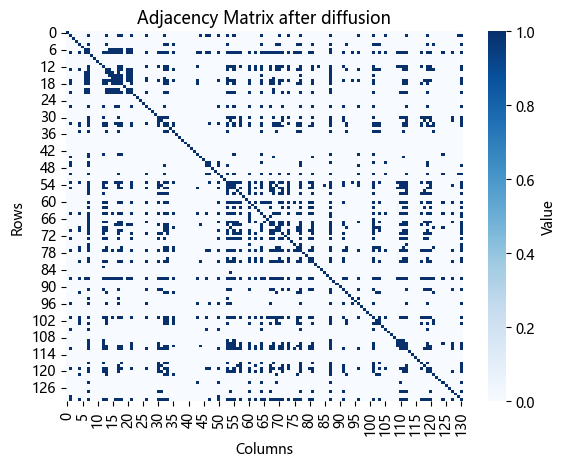

In [23]:
sns.heatmap(x2, cmap='Blues', cbar_kws={'label': 'Value'})
plt.title('Adjacency Matrix after diffusion')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()

In [24]:
labels =data["BRCA_Subtype_PAM50"]
label_mapping = {'LumA': 0, 'Basal': 1, 'Her2': 2, 'LumB':3,'Normal':4}
data['numeric_label'] = data['BRCA_Subtype_PAM50'].replace(label_mapping)
x=data[columns].astype(np.float32)
scaler = StandardScaler()
x= scaler.fit_transform(x)
x.shape

(739, 131)

In [25]:
y=data['numeric_label']
from tensorflow.keras.utils import to_categorical
y_encoded = to_categorical(y)
y_encoded.shape

(739, 5)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(x, y_encoded, test_size=0.2, random_state=42)

def build_model():
    X_in = Input(shape=(len(adjoint),1))
    A_in = Input((len(adjoint),len(adjoint)), sparse=True)

    X_1 = GATConv(1, activation='relu')([X_in, A_in])
    X_2 = Flatten()(X_1)

    output = Dense(5, activation='softmax')(X_2)

    model = Model(inputs=[X_in, A_in], outputs=output)
    return model

model = build_model()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 131, 1)]     0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 131, 131)]   0           []                               
                                                                                                  
 gat_conv_1 (GATConv)           (None, 131, 1)       4           ['input_3[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
 flatten_1 (Flatten)            (None, 131)          0           ['gat_conv_1[0][0]']       

In [27]:
xtrain= np.expand_dims(X_train, axis=2)
print("x train",xtrain.shape)

xtest= np.expand_dims(X_test, axis=2)
print("x test",xtest.shape)


adjoint1 = np.array(x2)[np.newaxis,:,:]
adjoint2 = np.repeat(adjoint1,len(xtrain),0)
adjoint3 = np.repeat(adjoint1,len(xtest),0)
print("A",adjoint2.shape)

x train (591, 131, 1)
x test (148, 131, 1)
A (591, 131, 131)


In [28]:
model.fit([xtrain, adjoint2], y_train, batch_size=32, epochs=100, validation_split=0.2)

Epoch 1/100
15/15 [==============================] - 1s 28ms/step - loss: 2.2704 - accuracy: 0.1335 - val_loss: 1.7621 - val_accuracy: 0.1933
Epoch 2/100
15/15 [==============================] - 0s 12ms/step - loss: 1.9860 - accuracy: 0.1907 - val_loss: 1.5046 - val_accuracy: 0.3529
Epoch 3/100
15/15 [==============================] - 0s 11ms/step - loss: 1.6958 - accuracy: 0.2818 - val_loss: 1.3653 - val_accuracy: 0.4454
Epoch 4/100
15/15 [==============================] - 0s 8ms/step - loss: 1.6154 - accuracy: 0.3538 - val_loss: 1.2847 - val_accuracy: 0.5126
Epoch 5/100
15/15 [==============================] - 0s 8ms/step - loss: 1.5084 - accuracy: 0.3771 - val_loss: 1.2249 - val_accuracy: 0.5462
Epoch 6/100
15/15 [==============================] - 0s 8ms/step - loss: 1.4181 - accuracy: 0.4195 - val_loss: 1.1752 - val_accuracy: 0.5798
Epoch 7/100
15/15 [==============================] - 0s 8ms/step - loss: 1.4239 - accuracy: 0.4174 - val_loss: 1.1335 - val_accuracy: 0.6303
Epoch 8/10

In [29]:
y_pred=model.predict([xtest, adjoint3])

y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

recall = recall_score(y_test, y_pred, average='macro')
print("Recall:", recall)

precision = precision_score(y_test, y_pred, average='weighted')
print("Precision:", precision)

specificity = 1 - (sum((y_pred == 1) & (y_test == 0)) / sum(y_test == 0))
print("Specificity:", specificity)

f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 Score:", f1)

mcc = matthews_corrcoef(y_test, y_pred)
print("MCC:", mcc)

Accuracy: 0.8243243243243243
Recall: 0.6774891774891776
Precision: 0.8081807333985271
Specificity: 0.9714285714285714
F1 Score: 0.8145034880860322
MCC: 0.7426674064645954


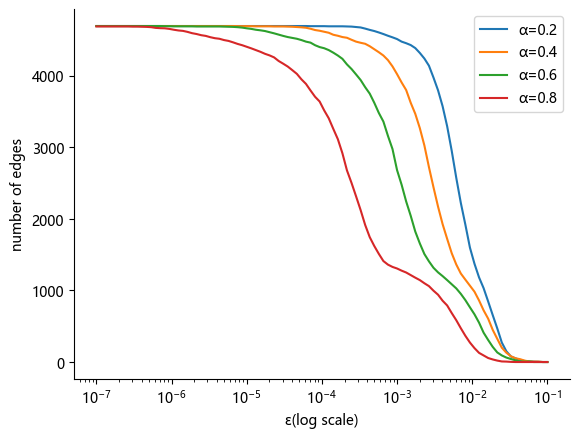

In [30]:
plt.rcParams['font.family'] = ['Microsoft YaHei']

def calculate_y(alpha,x):
    x=Diffusion(sparse_matrix1,alpha,x)
    df=pd.DataFrame(x)
    for i in range(0,len(df)):
        df.iloc[i,i]=0
    non_zero_count = df[df != 0].count().sum()
    return non_zero_count

def plot_curve(x_values, y_values, title="", x_label="", y_label=""):
    plt.figure()
    plt.plot(x_values, y_values)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(True)
    plt.show()

start_exp = -7  
end_exp = -1    
num_points = 100  

x_values = np.logspace(start_exp, end_exp, num=num_points)


y_values1 = [calculate_y(0.2,x) for x in x_values]
y_values2 = [calculate_y(0.4,x) for x in x_values]
y_values3 = [calculate_y(0.6,x) for x in x_values]
y_values4 = [calculate_y(0.8,x) for x in x_values]

plt.semilogx(x_values, y_values1, label='α=0.2')
plt.semilogx(x_values, y_values2, label='α=0.4')
plt.semilogx(x_values, y_values3, label='α=0.6')
plt.semilogx(x_values, y_values4, label='α=0.8')

plt.grid(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.xlabel("ε(log scale)")
plt.ylabel("number of edges")
plt.legend()
plt.show()